In [1]:
import sys; sys.path.insert(0, '../');
from ccqe_notebook_tools import *
from tracking_tools import *
from scipy.optimize import curve_fit
%matplotlib inline

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Welcome to ROOTaaS 6.06/02

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent cumputeAnaTree!


## MCC8 - MC-BNB + extBNB overlay

In [13]:
MCC8_MCBNB_extBNB = pd.read_csv('/Users/erezcohen/Desktop/uBoone/analysis/ccqe_candidates/ccqe_candidates_GENIECC1p_MCC8_MC_BNB_extBNB.csv')
print len(MCC8_MCBNB_extBNB),'CC1p in MCC8 MC-BNB extBNB'

12976 CC1p in MCC8 MC-BNB extBNB


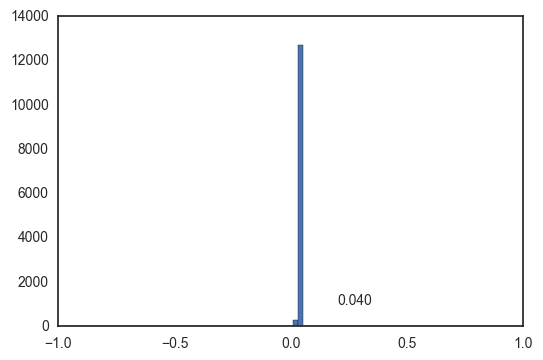

In [14]:
x = MCC8_MCBNB_extBNB['truth_Ev']-(MCC8_MCBNB_extBNB['truth_Emu']+MCC8_MCBNB_extBNB['truth_Ep']-0.939)
plt.hist(x,bins=np.linspace(-1,1,100));
plt.text(0.2,1000,'%.3f'%(np.mean(x)))

In [15]:
MCC8_MCBNB_extBNBIsVertexContained = MCC8_MCBNB_extBNB[MCC8_MCBNB_extBNB.IsVertexContained==True]
print len(MCC8_MCBNB_extBNBIsVertexContained),'contained',(100*float(len(MCC8_MCBNB_extBNBIsVertexContained))/len(MCC8_MCBNB_extBNB)),'%'
MCC8_MCBNB_extBNBIsMuonReconstructed = MCC8_MCBNB_extBNBIsVertexContained[MCC8_MCBNB_extBNBIsVertexContained.IsMuonReconstructed==True]
print len(MCC8_MCBNB_extBNBIsMuonReconstructed),'muon reconstructed',(100*float(len(MCC8_MCBNB_extBNBIsMuonReconstructed))/len(MCC8_MCBNB_extBNB)),'%'
MCC8_MCBNB_extBNBIsVertexReconstructed = MCC8_MCBNB_extBNBIsVertexContained[MCC8_MCBNB_extBNBIsVertexContained.IsVertexReconstructed==True]
print len(MCC8_MCBNB_extBNBIsVertexReconstructed),'tracks reconstructed',(100*float(len(MCC8_MCBNB_extBNBIsVertexReconstructed))/len(MCC8_MCBNB_extBNB)),'%'
GENIECC1p_in_FV = sample_in_FV( MCC8_MCBNB_extBNBIsVertexReconstructed )
GENIECC1p_in_FV_close_proximity = GENIECC1p_in_FV[GENIECC1p_in_FV['distance']<11]
print len(GENIECC1p_in_FV_close_proximity),'tracks reconstructed and contained with a separation distance below 11 cm',(100*float(len(GENIECC1p_in_FV_close_proximity))/len(MCC8_MCBNB_extBNB)),'%'

6365 contained 49.0520961776 %
4873 muon reconstructed 37.553945746 %
1167 tracks reconstructed 8.99352651048 %
757 tracks reconstructed and contained with a separation distance below 11 cm 5.83384710234 %


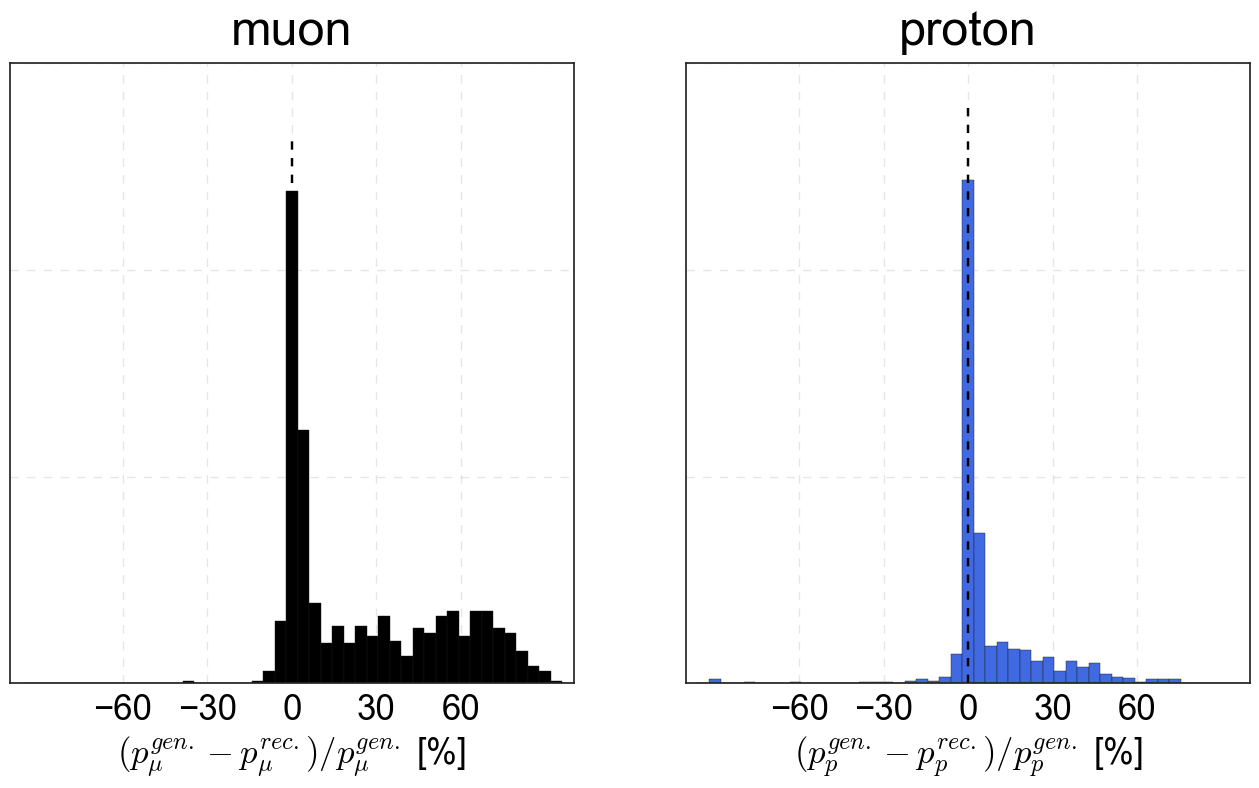

In [16]:
ticks_color='black'
bins = np.linspace(-100,100,50)
sample = GENIECC1p_in_FV_close_proximity
fig=plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,2,1)
ax.set_title('muon',fontsize=35,color=ticks_color,y=1.02)
ratio = 100*(sample['truth_Emu'] - sample['reco_CC1p_Emu'])/sample['truth_Emu']
plt.hist( ratio , bins=bins, color='black',normed=1);
set_axes(ax,'$(p^{gen.}_{\\mu}-p^{rec.}_{\\mu})/p^{gen.}_{\\mu}$ [%]',ticks_color=ticks_color)
ax.grid(linestyle='--',alpha=0.5)
ax.legend(loc='best',fontsize=15)
plt.plot([0,0],ax.get_ylim(),'--',color='black')
ax.xaxis.set_ticks([-60,-30,0,30,60])
ax.yaxis.set_major_formatter(ticker.NullFormatter())


ax = fig.add_subplot(1,2,2)
ax.set_title('proton',fontsize=35,color=ticks_color,y=1.02)
ratio = 100*(sample['truth_Pp'] - sample['reco_CC1p_Pp'])/sample['truth_Pp']
plt.hist( ratio , bins=bins, color='royalblue',normed=1);
set_axes(ax,'$(p^{gen.}_{p}-p^{rec.}_{p})/p^{gen.}_{p}$ [%]',ticks_color=ticks_color)
ax.grid(linestyle='--',alpha=0.5)
ax.legend(loc='best',fontsize=15)
plt.plot([0,0],ax.get_ylim(),'--',color='black')
ax.xaxis.set_ticks([-60,-30,0,30,60])
ax.yaxis.set_major_formatter(ticker.NullFormatter())

In [17]:
def pow_func(x, a, b, c):
    return a*np.power(x,b) + c

def correct_momentum_from_theta(sample = MCC8_MCBNB_extBNBIsVertexReconstructed,varx = 'Pmu_theta',vary = 'Pmu',
                                corr_type = 'pow_func(x, *popt_true)',ticks_color='white'):

    fig=plt.figure(figsize=(28,8))
    ax=fig.add_subplot(1,2,1)

    x = 180./np.pi*sample['reco_CC1p_'+varx]
    y_reco = sample['reco_CC1p_'+vary]
    y_true = sample['truth_'+vary]
    ax.scatter(x,y_reco,s=10,color='blue',label='$p^{rec.}_{\\mu}$')
    ax.scatter(x,y_true,s=10,color='green',label='$p^{gen.}_{\\mu}$')
    set_axes(ax,'$\\bf{\\theta^{rec.}_{\\mu}}$ [deg.]','$\\bf{p_{\\mu}}$ [GeV/c]' ,fontsize=40,ticks_color=ticks_color)
    ax.set_ylim(0.05,5)
    ax.legend(fontsize=45 , markerscale=3., scatterpoints=4 )
    ax.grid(linestyle='--',alpha=0.5)
    ax.xaxis.set_ticks([0,45,90,135,180])
    plt.tight_layout()

    x_fit = np.linspace(np.min(ax.get_xlim()), np.max(ax.get_xlim()), 100)
    popt_reco, pcov_reco = curve_fit(pow_func, x, y_reco , (1,-0.5,0), maxfev=5000)
    plt.plot(x_fit, pow_func(x_fit, *popt_reco), '--', c='blue',linewidth=3)
    popt_true, pcov_true = curve_fit(pow_func, x, y_true , (1,-0.5,0), maxfev=5000)
    plt.plot(x_fit, pow_func(x_fit, *popt_true), '--', c='green',linewidth=3)

    if corr_type == 'y_reco + pow_func(x, *popt_true) - pow_func(x, *popt_reco)':
        y_corrected = y_reco + pow_func(x, *popt_true) - pow_func(x, *popt_reco)
        print 'reco_CC1p_'+vary+'_corrected = ' + 'reco_CC1p_'+vary + " + (%f*power(%s , %f)+%f)"%(popt_true[0],'reco_CC1p_'+varx,popt_true[1],popt_true[2]) + " - (%f*power(%s , %f)+%f)"%(popt_reco[0],'reco_CC1p_'+varx,popt_reco[1],popt_reco[2]) 
    elif corr_type == 'y_reco * pow_func(x, *popt_true) / pow_func(x, *popt_reco)':
        y_corrected = y_reco * pow_func(x, *popt_true) / pow_func(x, *popt_reco)
        print 'reco_CC1p_'+vary+'_corrected = ' + 'reco_CC1p_'+vary + " + (%f*power(%s , %f)+%f)"%(popt_true[0],'reco_CC1p_'+varx,popt_true[1],popt_true[2]) + " - (%f*power(%s , %f)+%f)"%(popt_reco[0],'reco_CC1p_'+varx,popt_reco[1],popt_reco[2]) 

    elif corr_type == 'pow_func(x, *popt_true)':
        y_corrected = pow_func(x, *popt_true)
        print 'reco_CC1p_'+vary+'_corrected = ' + "(%f*power(%s , %f)+%f)"%(popt_true[0],'reco_CC1p_'+varx,popt_true[1],popt_true[2]) 
    elif corr_type == 'y_reco + np.mean(y_true) - np.mean(y_reco)':
#         mean_reco_ratio = np.mean(y_true/y_reco)        
#         y_corrected = y_reco * mean_reco_ratio
        y_corrected = y_reco + np.mean(y_true) - np.mean(y_reco)
        
        print 'reco_CC1p_'+vary+'_corrected = ' + 'reco_CC1p_'+vary + " + (%f-%f)"%( np.mean(y_true) , np.mean(y_reco) ) 

    elif corr_type=='no correction':
        y_corrected = y_reco
        
    ax.scatter(x,y_corrected,s=30,color='black',label='$p^{rec.}_{\\mu}$',alpha=0.3)

    ax=fig.add_subplot(1,2,2)
    bins=np.linspace(-1,1,50)
    plt.hist((y_true-y_reco)/y_true,color='royalblue',bins=bins,label='before correction',histtype='step',linewidth=3)
    if corr_type!='no correction':
        plt.hist((y_true-y_corrected)/y_true,color='black',bins=bins,label='after correction',histtype='step',linewidth=3)
    set_axes(ax,'$\\bf{(p^{gen.}_{\\mu}-p^{rec.}_{\\mu})/p^{gen.}_{\\mu}}$',fontsize=40,ticks_color=ticks_color)
    ax.xaxis.set_ticks([-1,-0.3,0.3,1])
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    plt.plot([0,0],ax.get_ylim(),'--',color='black')    
    plt.tight_layout()
    
    return y_corrected

In [115]:
GENIECC1p_in_FV_close_proximity.index

Int64Index([    6,    14,    56,    74,    98,   156,   248,   305,   325,
              338,
            ...
            12785, 12800, 12829, 12840, 12844, 12854, 12855, 12904, 12955,
            12970],
           dtype='int64', length=757)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


757


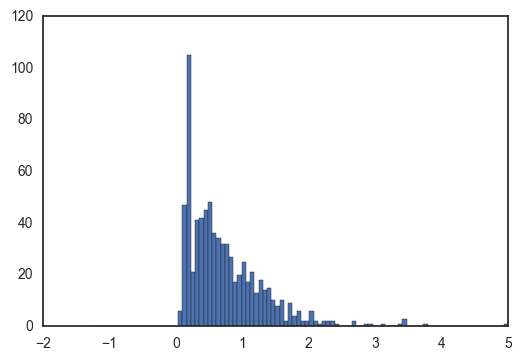

In [116]:
GENIECC1p_in_FV_close_proximity['reco_CC1p_max_Pmu_msllhd'] = 0.0
print len(GENIECC1p_in_FV_close_proximity)
for i in GENIECC1p_in_FV_close_proximity.index:
    GENIECC1p_in_FV_close_proximity.set_value(i,'reco_CC1p_max_Pmu_msllhd',
                                             np.max([GENIECC1p_in_FV_close_proximity.get_value(i,'reco_CC1p_Pmu')
                                                     ,GENIECC1p_in_FV_close_proximity.get_value(i,'mommsllhd_assigned_muon')]))
plt.hist(GENIECC1p_in_FV_close_proximity['reco_CC1p_max_Pmu_msllhd'] ,bins=np.linspace(-1.3,5,100));

In [110]:
GENIECC1p_in_FV_close_proximity['reco_CC1p_Q_fromE'] = np.sqrt(GENIECC1p_in_FV_close_proximity['reco_CC1p_Q2_fromE'])
GENIECC1p_in_FV_close_proximity['reco_CC1p_XbW2_fromE'] = GENIECC1p_in_FV_close_proximity['reco_CC1p_Xb_fromE']*GENIECC1p_in_FV_close_proximity['reco_CC1p_W2_fromE']
GENIECC1p_in_FV_close_proximity['reco_CC1p_W4_fromE'] = GENIECC1p_in_FV_close_proximity['reco_CC1p_W2_fromE']*GENIECC1p_in_FV_close_proximity['reco_CC1p_W2_fromE']
GENIECC1p_in_FV_close_proximity['reco_CC1p_Pmu_msllhd'] = 0.5*(GENIECC1p_in_FV_close_proximity['reco_CC1p_Pmu']+GENIECC1p_in_FV_close_proximity['mommsllhd_assigned_muon'])
GENIECC1p_in_FV_close_proximity['truth_Pmu_msllhd'] = GENIECC1p_in_FV_close_proximity['truth_Pmu']
GENIECC1p_in_FV_close_proximity['truth_max_Pmu_msllhd'] = GENIECC1p_in_FV_close_proximity['truth_Pmu']





truth_good_sample = GENIECC1p_in_FV_close_proximity[np.abs(GENIECC1p_in_FV_close_proximity['truth_Pmu']-GENIECC1p_in_FV_close_proximity['reco_CC1p_Pmu'])/GENIECC1p_in_FV_close_proximity['truth_Pmu']<0.1]
truth_bad_sample = GENIECC1p_in_FV_close_proximity[np.abs(GENIECC1p_in_FV_close_proximity['truth_Pmu']-GENIECC1p_in_FV_close_proximity['reco_CC1p_Pmu'])/GENIECC1p_in_FV_close_proximity['truth_Pmu']>0.1]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

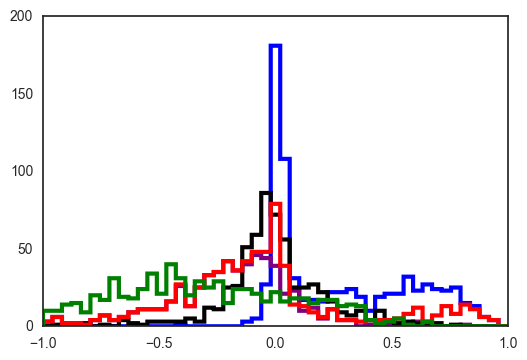

In [117]:
sample = GENIECC1p_in_FV_close_proximity#detected_bad_sample
plt.hist((sample['truth_Pmu']-sample['reco_CC1p_Pmu'])/sample['truth_Pmu'],color='blue',bins=bins,label='range',histtype='step',linewidth=3);
plt.hist((sample['truth_Pmu']-sample['mommsllhd_assigned_muon'])/sample['truth_Pmu'],color='purple',bins=bins,label='msc',histtype='step',linewidth=3);
plt.hist((sample['truth_Pmu']-0.5*(sample['reco_CC1p_Pmu']+sample['mommsllhd_assigned_muon']))/sample['truth_Pmu'],color='black',bins=bins,label='avg.(range,msc)',histtype='step',linewidth=3);
plt.hist((sample['truth_Pmu']-sample['reco_CC1p_max_Pmu_msllhd'])/sample['truth_Pmu'],color='red',bins=bins,label='max.(range,msc)',histtype='step',linewidth=3);
plt.hist((sample['truth_Pmu']-sample['reco_CC1p_Pmu_corrected'])/sample['truth_Pmu'],color='green',bins=bins,label='range',histtype='step',linewidth=3);



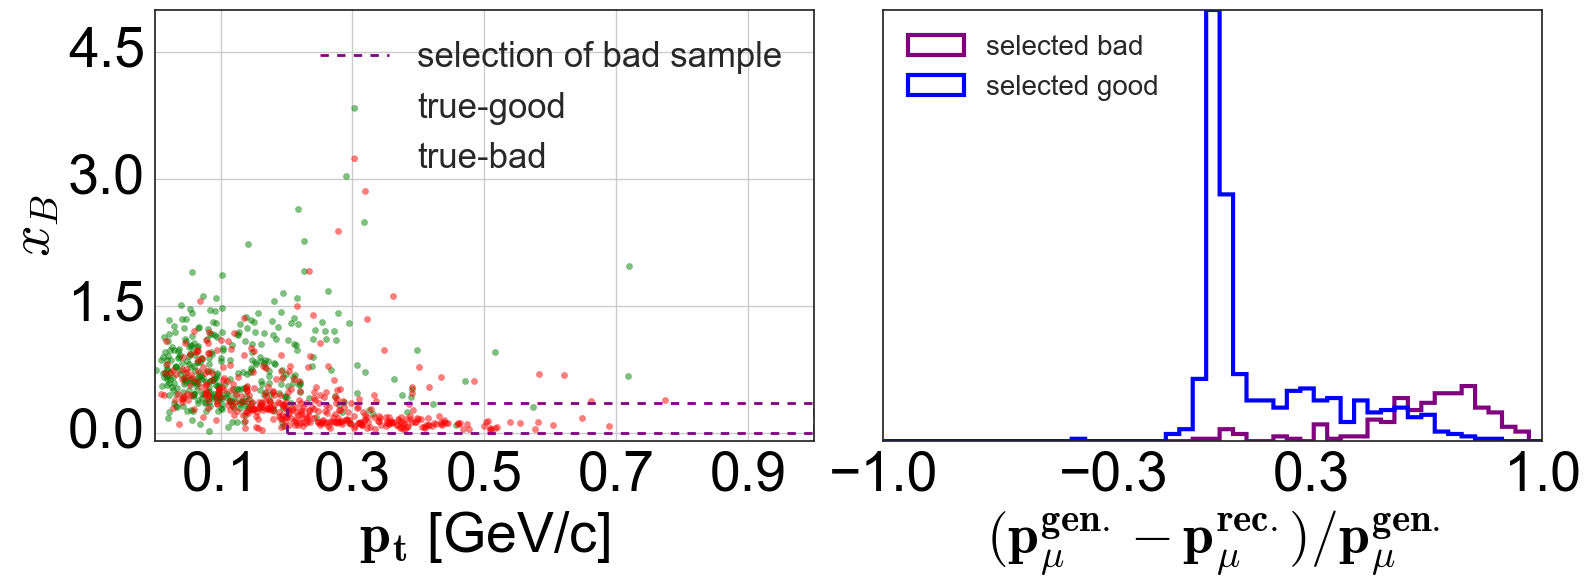

In [122]:
varx = 'reco_CC1p_Pt'
min_x, max_x = 0.2,1
vary = 'reco_CC1p_Xb_fromE'
min_y, max_y = 0.0,0.35
# varx = 'reco_CC1p_Q_fromE'
# min_x, max_x = 0.,35
# vary = 'reco_CC1p_W4_fromE'
# min_y, max_y = 1.1,3.15

ticks_color = 'black'
fig=plt.figure(figsize=(16,6))
bins=np.linspace(0,1,100)
ax=fig.add_subplot(1,2,1)
for sample,label,color in zip([truth_good_sample,truth_bad_sample],['true-good','true-bad'],['green','red']):
    ax.scatter(sample[varx]
               ,sample[vary]
               ,label=label,color=color,s=20,alpha=0.5)
plt.plot([min_x,min_x],[min_y,max_y],'--',color='purple',linewidth=2)
plt.plot([min_x,max_x],[min_y,min_y],'--',color='purple',linewidth=2)
plt.plot([max_x,max_x],[min_y,max_y],'--',color='purple',linewidth=2)
plt.plot([min_x,max_x],[max_y,max_y],'--',color='purple',linewidth=2,label='selection of bad sample')
ax.legend(fontsize=25)
ax.grid()
ax.set_xlim(0,1);
ax.set_ylim(-0.1,5);
set_axes(ax,'$\\bf{p_{t}}$ [GeV/c]','$x_{B}$',fontsize=40,ticks_color=ticks_color)
ax.xaxis.set_ticks([0.1,0.3,0.5,0.7,0.9])
ax.yaxis.set_ticks([0,1.5,3,4.5])

sample = GENIECC1p_in_FV_close_proximity
detected_good_sample = sample[(((sample[varx]>min_Pt)&(sample[varx]<max_Pt)
                              &(sample[vary]>min_y)&(sample[vary]<max_y))==False)]
detected_bad_sample = sample[(((sample[varx]>min_Pt)&(sample[varx]<max_Pt)
                              &(sample[vary]>min_y)&(sample[vary]<max_y))==True)]
sample_before_correction = pd.concat([detected_bad_sample,detected_good_sample])
ax=fig.add_subplot(1,2,2)
bins=np.linspace(-1,1,50)
plt.hist((detected_bad_sample['truth_Pmu']-detected_bad_sample['reco_CC1p_Pmu'])/detected_bad_sample['truth_Pmu'],color='purple',bins=bins,label='selected bad',histtype='step',linewidth=3)
plt.hist((detected_good_sample['truth_Pmu']-detected_good_sample['reco_CC1p_Pmu'])/detected_good_sample['truth_Pmu'],color='blue',bins=bins,label='selected good',histtype='step',linewidth=3)
set_axes(ax,'$\\bf{(p^{gen.}_{\\mu}-p^{rec.}_{\\mu})/p^{gen.}_{\\mu}}$',fontsize=40,ticks_color=ticks_color)
ax.xaxis.set_ticks([-1,-0.3,0.3,1])
ax.yaxis.set_major_formatter(ticker.NullFormatter())
ax.legend(fontsize=20,loc='upper left')
plt.tight_layout()

reco_CC1p_Pmu_corrected = reco_CC1p_Pmu + (6.624009*power(reco_CC1p_Pmu_theta , -0.448648)+-0.452007) - (2.501489*power(reco_CC1p_Pmu_theta , -0.151017)+-1.167534)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


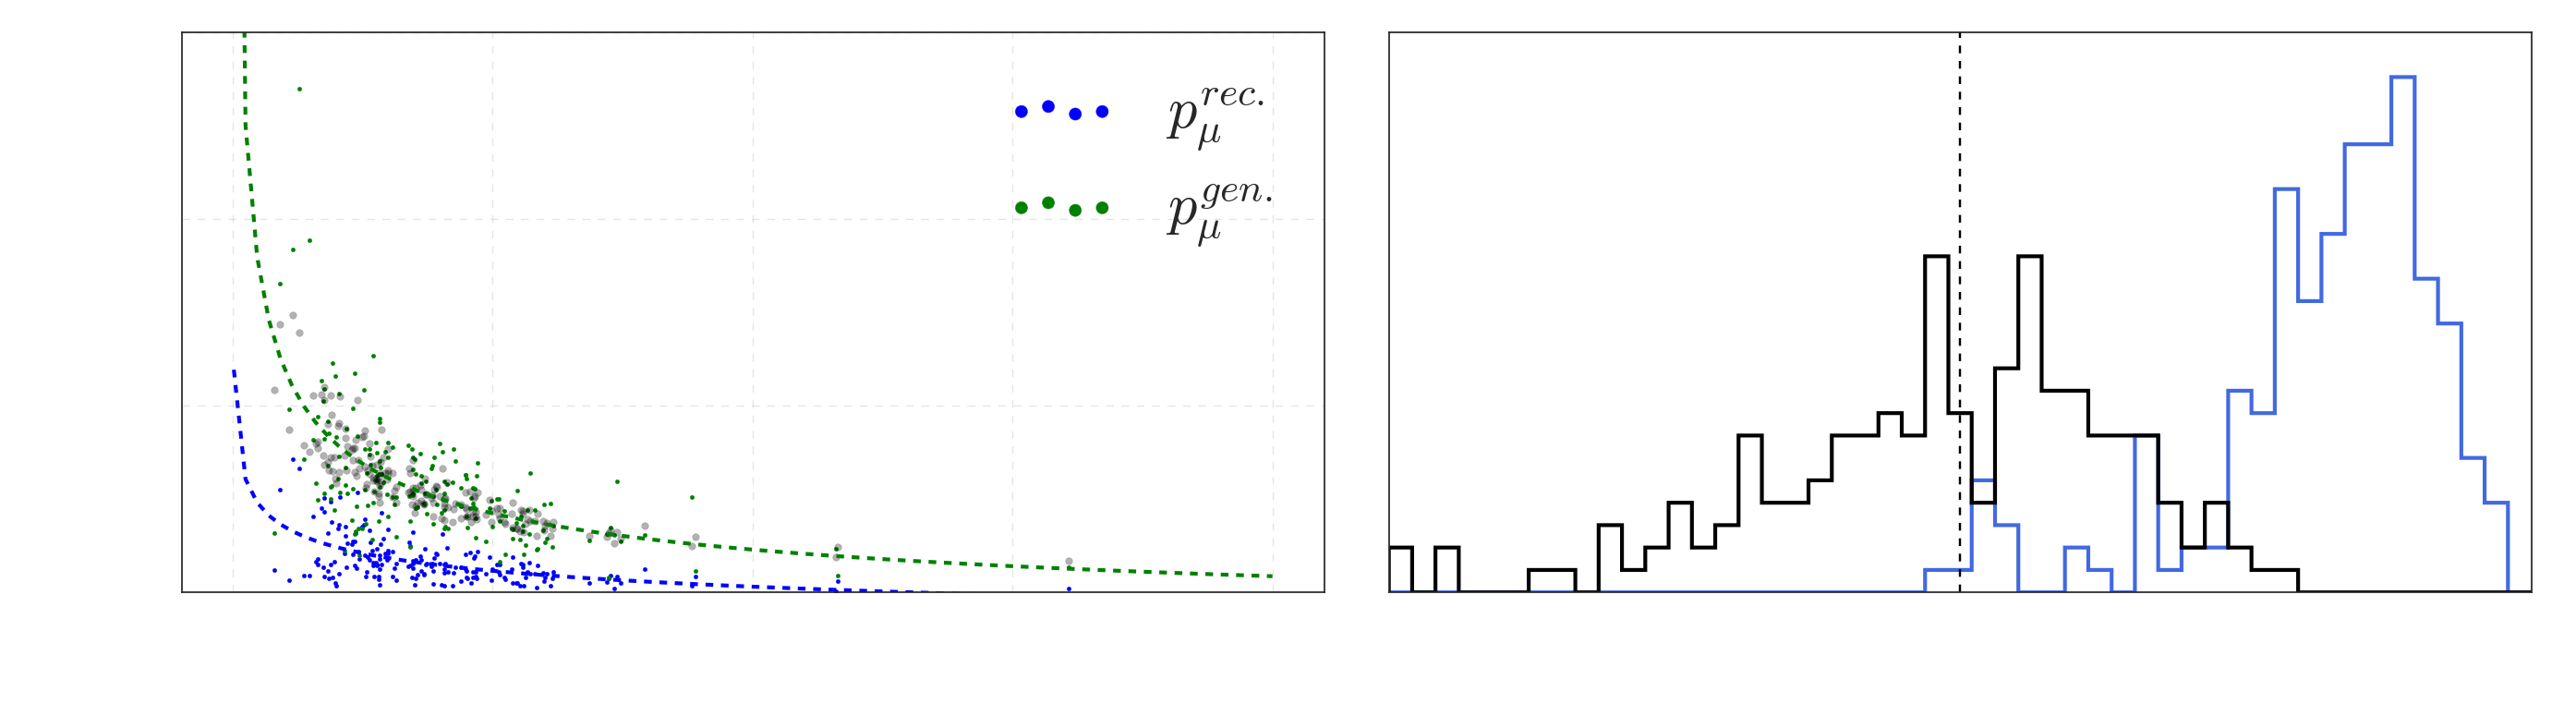

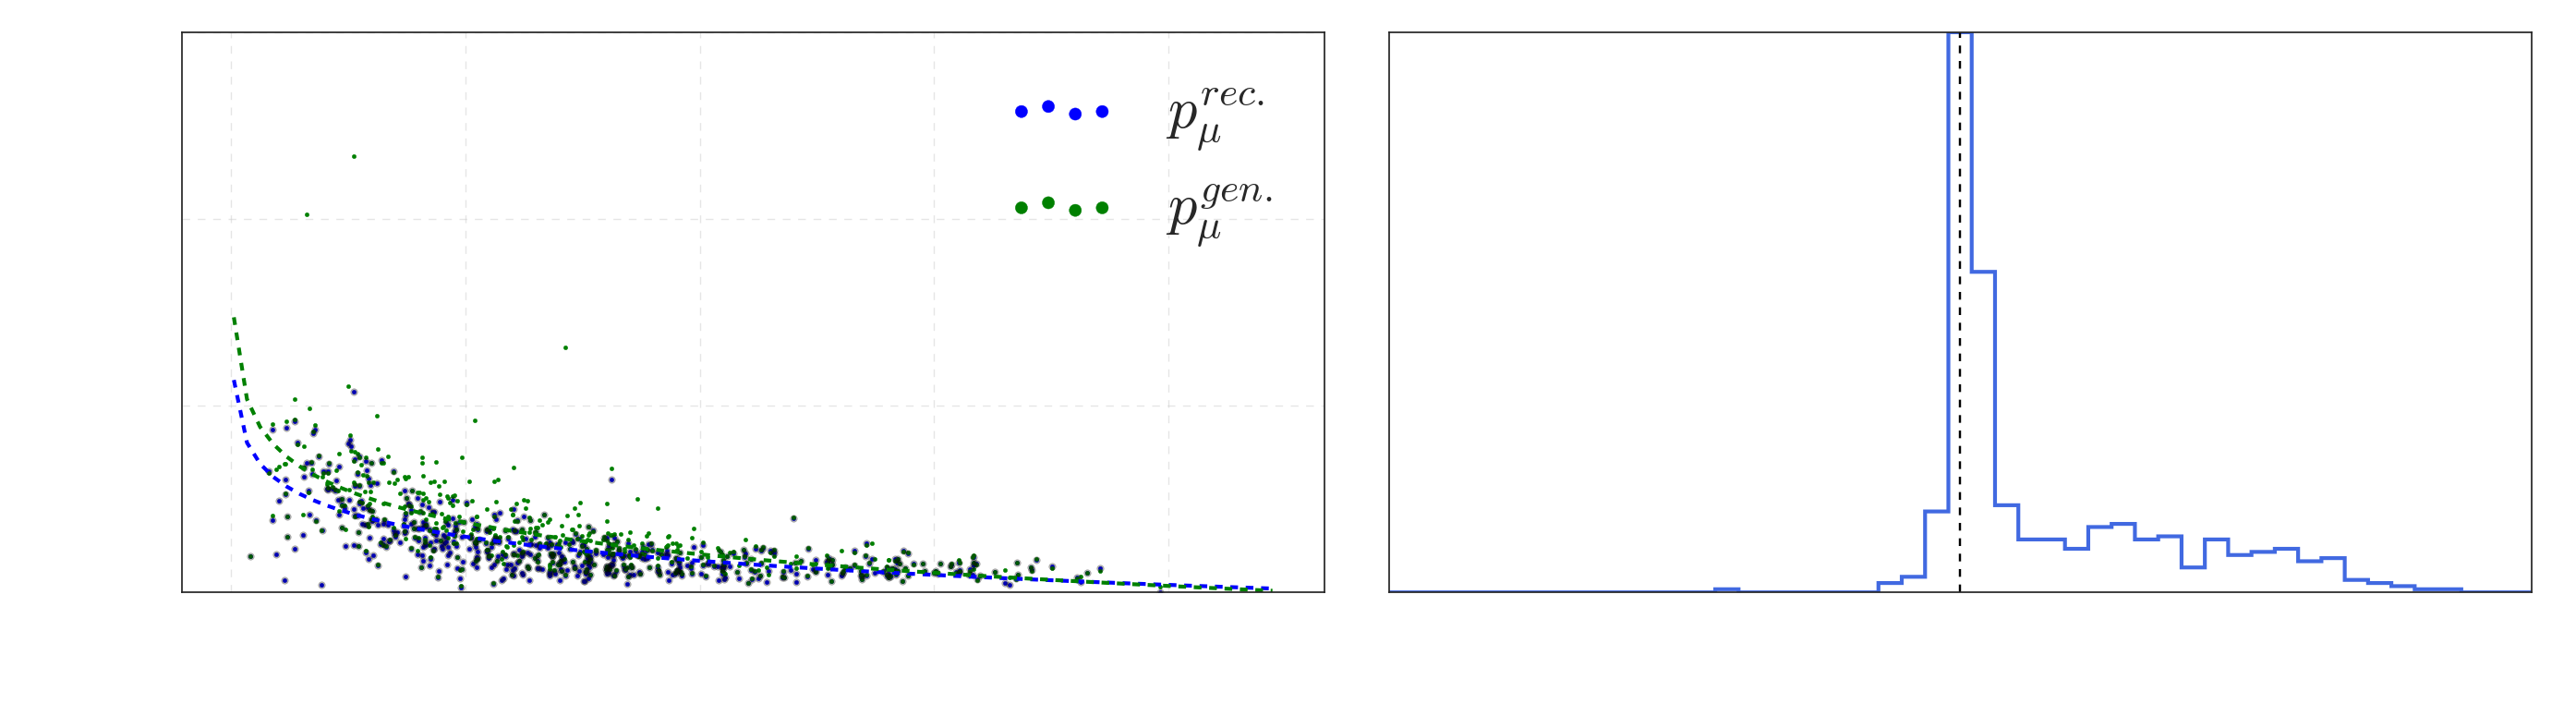

In [125]:
detected_bad_sample['reco_CC1p_Pmu_corrected'] = correct_momentum_from_theta(sample = detected_bad_sample,vary='Pmu'
                            ,corr_type = 'y_reco + pow_func(x, *popt_true) - pow_func(x, *popt_reco)' );#'pow_func(x, *popt_true)'
# detected_bad_sample['reco_CC1p_Pmu_corrected'] = correct_momentum_from_theta(sample = detected_bad_sample
#                             ,corr_type = 'y_reco * pow_func(x, *popt_true) / pow_func(x, *popt_reco)' );
# detected_bad_sample['reco_CC1p_Pmu_corrected'] = correct_momentum_from_theta(sample = detected_bad_sample
#                             ,corr_type = 'y_reco + np.mean(y_true) - np.mean(y_reco)');
detected_good_sample['reco_CC1p_Pmu_corrected'] = correct_momentum_from_theta(sample = detected_good_sample
                            ,corr_type = 'no correction');

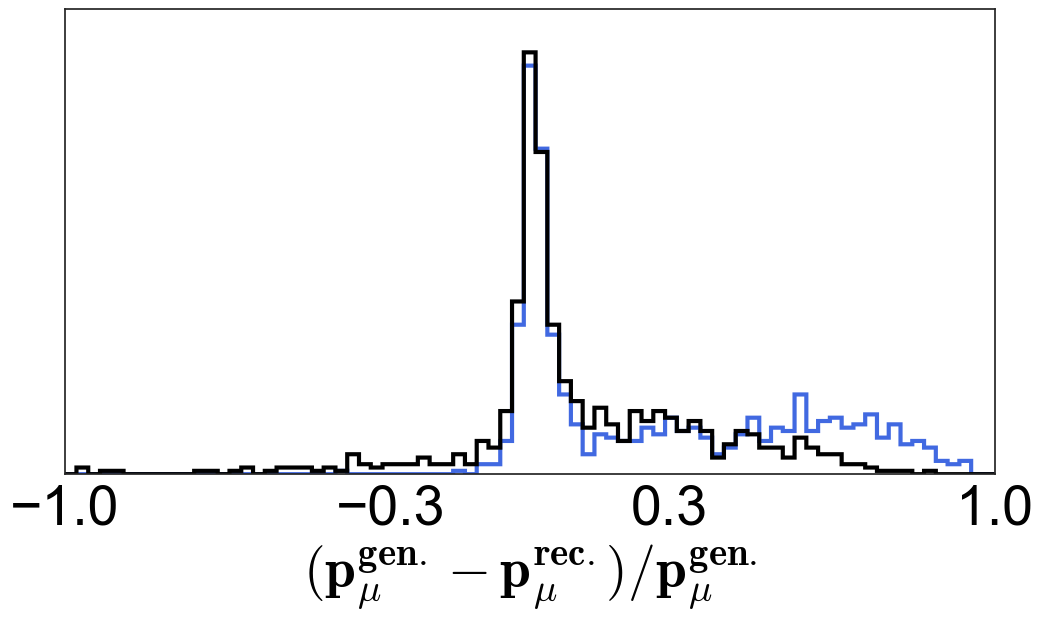

In [126]:
sample_after_correction = pd.concat([detected_bad_sample,detected_good_sample])
fig,ax=plt.subplots(figsize=(12,6))
bins=np.linspace(-1,1,80)
plt.hist((sample_after_correction['truth_Pmu']-sample_after_correction['reco_CC1p_Pmu'])/sample_after_correction['truth_Pmu'],color='royalblue',bins=bins,label='before correction',histtype='step',linewidth=3)
plt.hist((sample_after_correction['truth_Pmu']-sample_after_correction['reco_CC1p_Pmu_corrected'])/sample_after_correction['truth_Pmu'],color='black',bins=bins,label='after correction',histtype='step',linewidth=3)
set_axes(ax,'$\\bf{(p^{gen.}_{\\mu}-p^{rec.}_{\\mu})/p^{gen.}_{\\mu}}$',fontsize=40,ticks_color=ticks_color)
ax.xaxis.set_ticks([-1,-0.3,0.3,1])
ax.yaxis.set_major_formatter(ticker.NullFormatter())

In [39]:
def get_fraction_in_cut( data=None , cut_var='distance', mul=1 , xmin=0.1, xmax=10 , Nbins=10 ,  cut_type= 'max' ):
    x_array = np.linspace(xmin,xmax,Nbins)
    frac , frac_err = [] , []
    denominator = len(data)
    
    for x in x_array:
        if cut_type is 'max':
            reduced = data[mul*data[cut_var]<x]
        elif cut_type is 'min':
            reduced = data[mul*data[cut_var]>x]
        numerator = float(len(reduced))
         
        frac.append(100 * numerator / denominator)
        frac_err.append( frac[-1] * np.sqrt(1./numerator + 1./denominator) ) if numerator>0 else frac_err.append( frac[-1]/np.sqrt(denominator) )
        
    return np.array(x_array), np.array(frac) , np.array(frac_err)

def plot_cut_samples (samples=None,labels=None,
                      cut_name='maximal distance between tracks',mul=1,
                      cut_var ='distance',
                      cut_type= 'max',
                      x_label = 'maximal tracks distance [cm]', y_label='% of sample',
                      xcenter=0,figsize=(10,6),fontsize=35,
                      xmin=0.1, xmax=10 , Nbins=10, do_add_legend=True, ax=None,ticks_color='black'):
    do_return_fig = False
    if ax is None:
        do_return_fig = True
        fig,ax=plt.subplots(figsize=figsize)    
    for sample,label in zip(samples,labels):
        if cut_type=='max' or cut_type=='min':
            x , frac , frac_eff = get_fraction_in_cut( data=sample , cut_var=cut_var , mul=mul , cut_type=cut_type , xmin=xmin, xmax=xmax , Nbins=Nbins )
        elif cut_type=='symmetric':
            x , frac , frac_eff = get_fraction_in_symmetriccut( data=sample , cut_var=cut_var , mul=mul , xcenter=xcenter, delta_x_min=xmin, delta_x_max=xmax , Nbins=Nbins )
        plt.errorbar(x , y=frac, yerr=frac_eff , fmt='o' , markersize=10 , label=label)
    if do_add_legend:
        ax.legend(fontsize=25,loc='best')
    ax.set_ylim(0,101)
    ax.set_xlim(xmin,xmax)
    set_axes(ax,x_label=x_label,y_label=y_label,fontsize=fontsize,ticks_color=ticks_color)
    ax.grid(linestyle='--',alpha=0.75)
    plt.tight_layout()

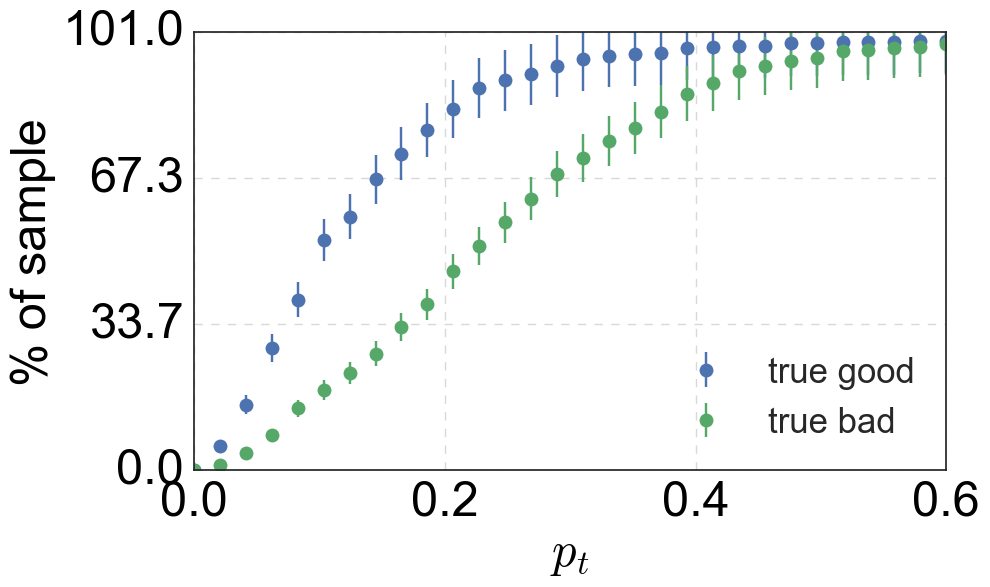

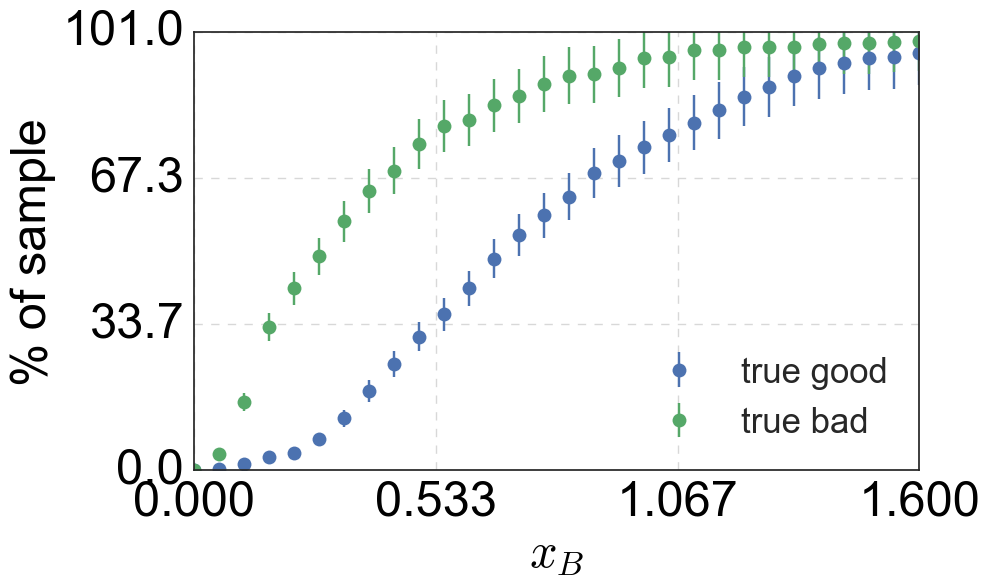

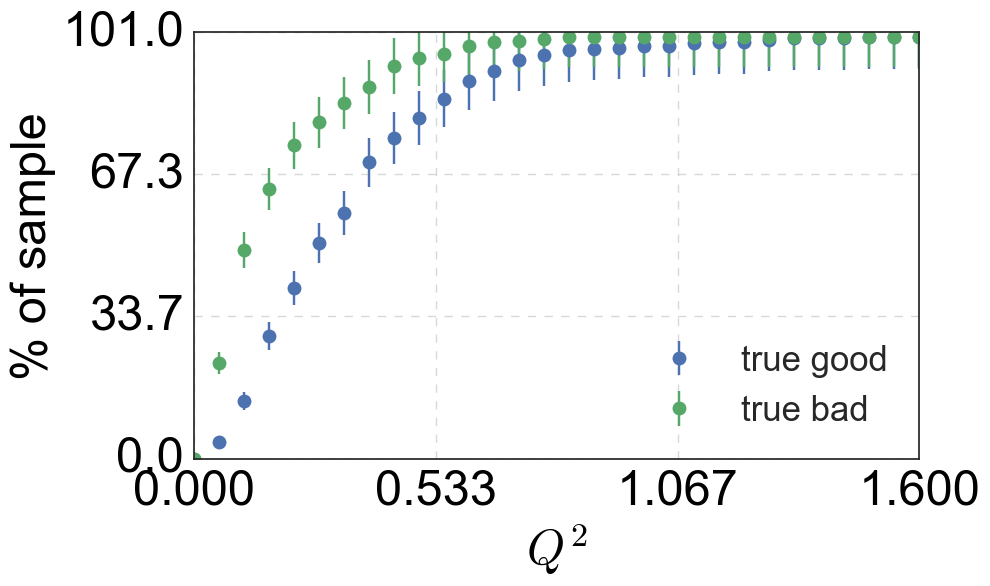

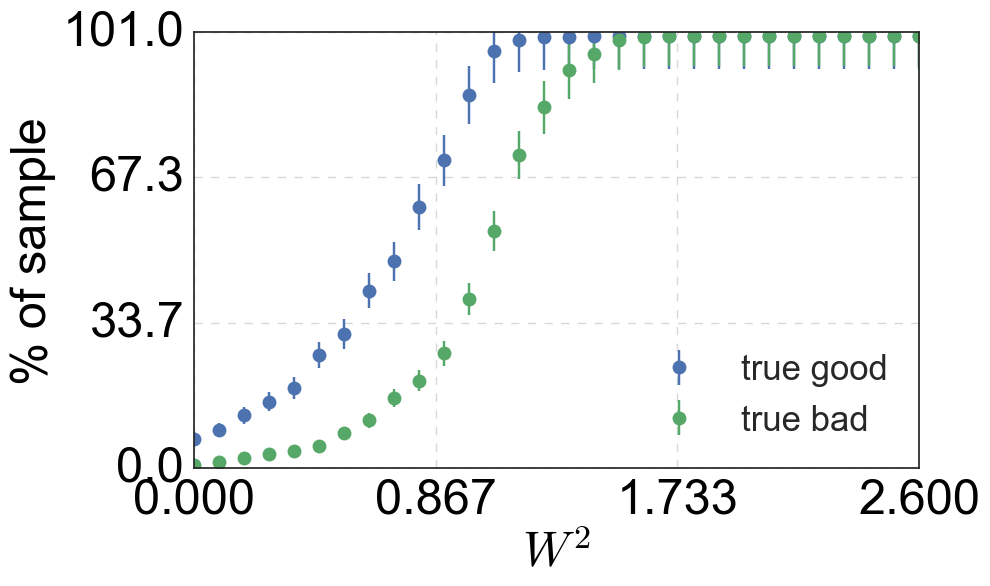

In [40]:
plot_cut_samples(samples=[truth_good_sample,truth_bad_sample]
                 ,labels=['true good','true bad'],cut_var='reco_CC1p_Pt',x_label='$p_t$',xmin=0.0, xmax=0.6 , Nbins=30)
plot_cut_samples(samples=[truth_good_sample,truth_bad_sample]
                 ,labels=['true good','true bad'],cut_var='reco_CC1p_Xb_fromE',x_label='$x_B$',xmin=0.0, xmax=1.6 , Nbins=30)
plot_cut_samples(samples=[truth_good_sample,truth_bad_sample]
                 ,labels=['true good','true bad'],cut_var='reco_CC1p_Q2_fromE',x_label='$Q^2$',xmin=0.0, xmax=1.6 , Nbins=30)
plot_cut_samples(samples=[truth_good_sample,truth_bad_sample]
                 ,labels=['true good','true bad'],cut_var='reco_CC1p_W2_fromE',x_label='$W^2$',xmin=0.0, xmax=2.6 , Nbins=30)

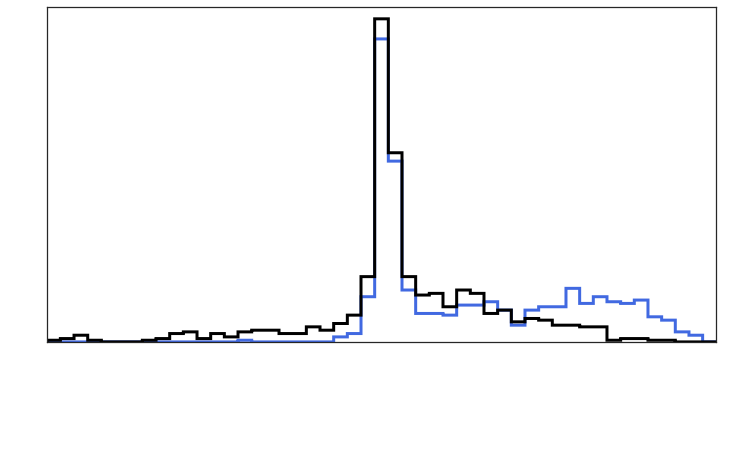

In [24]:
sample_after_correction = pd.concat([detected_bad_sample,detected_good_sample])
fig,ax=plt.subplots(figsize=(12,6))
bins=np.linspace(-1,1,50)
plt.hist((sample_after_correction['truth_Pmu']-sample_after_correction['reco_CC1p_Pmu'])/sample_after_correction['truth_Pmu'],color='royalblue',bins=bins,label='before correction',histtype='step',linewidth=3)
plt.hist((sample_after_correction['truth_Pmu']-sample_after_correction['reco_CC1p_Pmu_corrected'])/sample_after_correction['truth_Pmu'],color='black',bins=bins,label='after correction',histtype='step',linewidth=3)
set_axes(ax,'$\\bf{(p^{gen.}_{\\mu}-p^{rec.}_{\\mu})/p^{gen.}_{\\mu}}$',fontsize=40,ticks_color=ticks_color)
#     ax.set_xlim(-1,1)
ax.xaxis.set_ticks([-1,-0.3,0.3,1])
#     ax.set_xlim(-1,190)
#     ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(ticker.NullFormatter())

757
reco_CC1p_Pmu_corrected = (11.979473*power(reco_CC1p_Pmu_theta , -0.048784)+-9.235757)


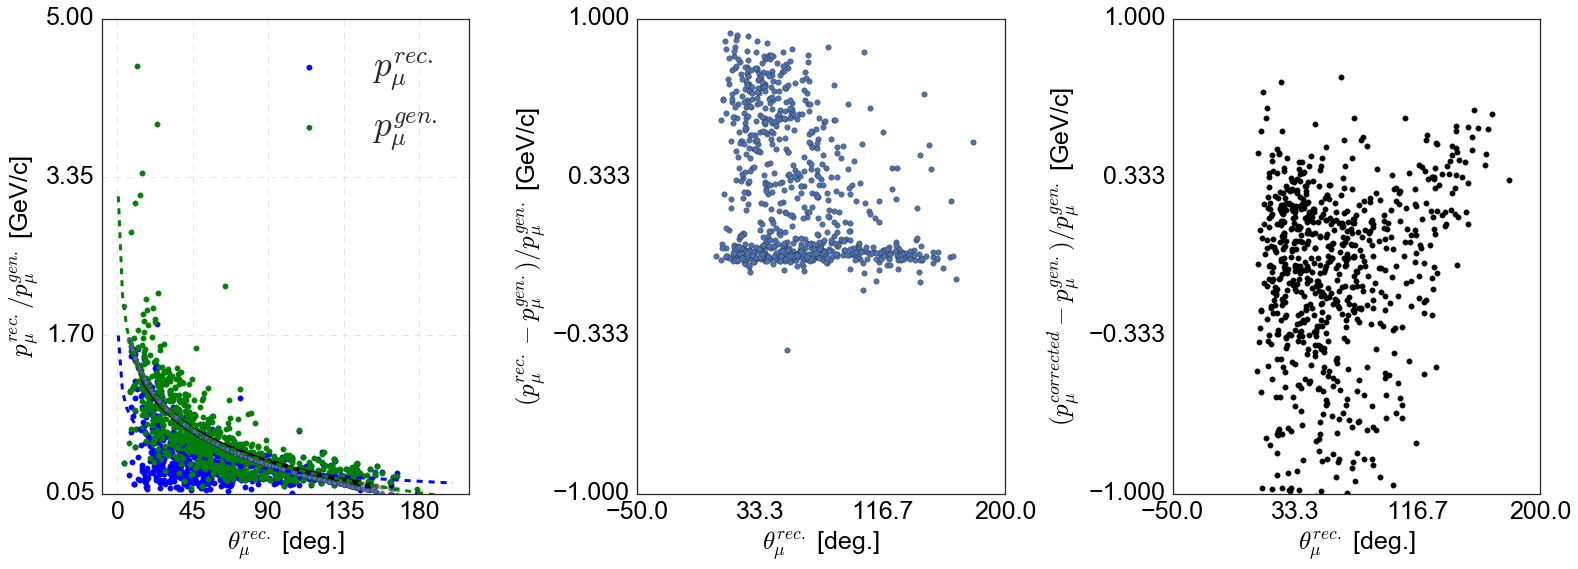

In [147]:
sample = GENIECC1p_in_FV_close_proximity

sample_notin_corridor = sample[(np.abs(sample['reco_CC1p_Pmu'] 
                                       - (11.979473*np.power(sample['reco_CC1p_Pmu_theta'] , -0.048784) -9.235757)) 
                                > 1.3)]
print len(sample_notin_corridor)
correct_momentum_from_theta(sample = sample_notin_corridor ,corr_type = 'pow_func(x, *popt_true)')

reco_CC1p_Pmu_corrected = reco_CC1p_Pmu + (2132.918305*power(reco_CC1p_Pmu_theta , -0.000275)+-2130.006223) - (-123.252663*power(reco_CC1p_Pmu_theta , -0.000144)+123.370531)


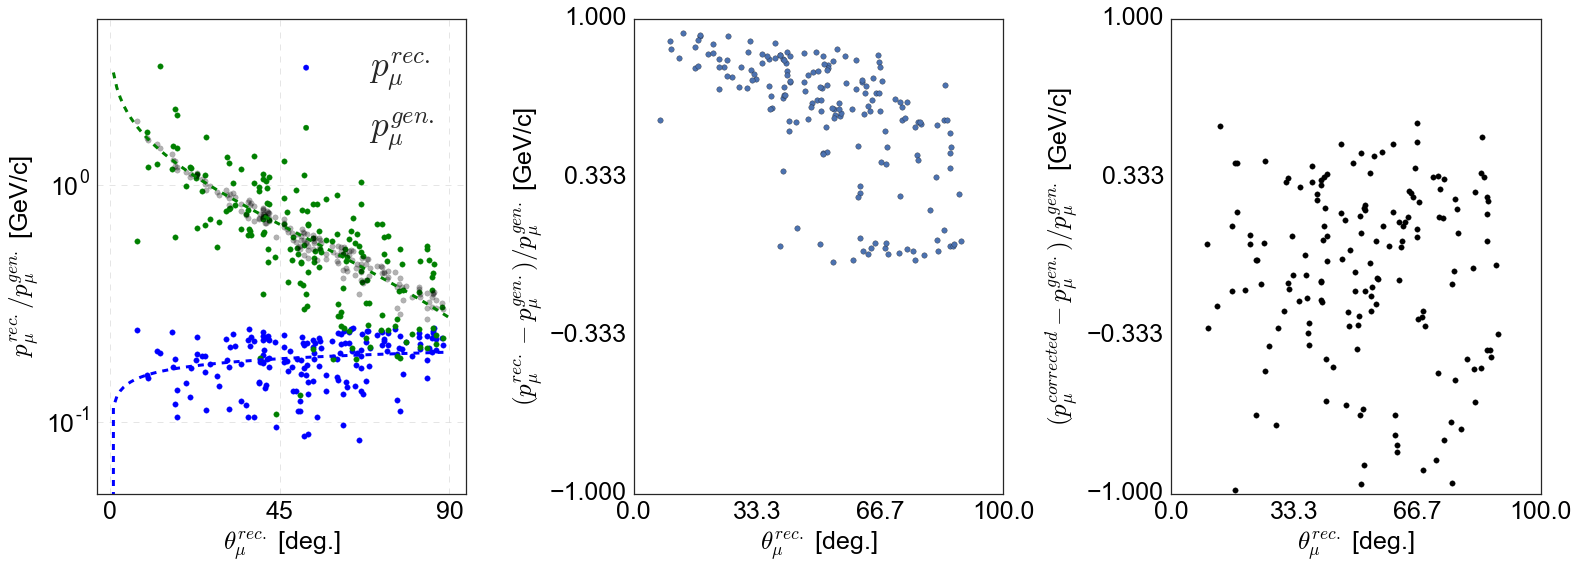

In [83]:
correct_momentum_from_theta(sample = MCC8_MCBNB_extBNBIsVertexReconstructed[(MCC8_MCBNB_extBNBIsVertexReconstructed['reco_CC1p_Pmu_theta']<np.pi/2)&(MCC8_MCBNB_extBNBIsVertexReconstructed['reco_CC1p_Pmu']<0.25)]
                            ,corr_type = 'y_reco + pow_func(x, *popt_true) - pow_func(x, *popt_reco)')

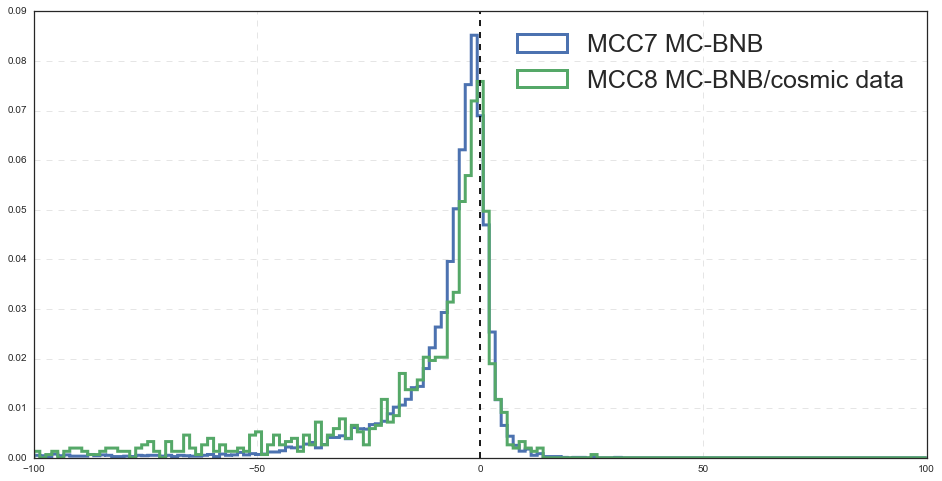

In [191]:
fig,ax=plt.subplots(figsize=(16,8))
bins = np.linspace(-100,100,150)
for sample,label in zip([MCC7_MCBNBIsVertexReconstructed , MCC8_MCBNB_extBNBIsVertexReconstructed]
                        ,['MCC7 MC-BNB','MCC8 MC-BNB/cosmic data']):
    x = sample['truth_theta_pq'] - sample['reco_CC1p_theta_pq_fromE']
    ratio = 100*(sample['truth_theta_pq'] - sample['reco_CC1p_theta_pq_fromE'])/sample['truth_theta_pq']
    plt.hist( x , bins=bins, label=label, histtype='step',linewidth=3,normed=1);
ax.grid(linestyle='--',alpha=0.5)
ax.legend(loc='best',fontsize=25)
plt.plot([0,0],ax.get_ylim(),'--',color='black')

popt_true: [ nan  nan  nan  nan  nan  nan]


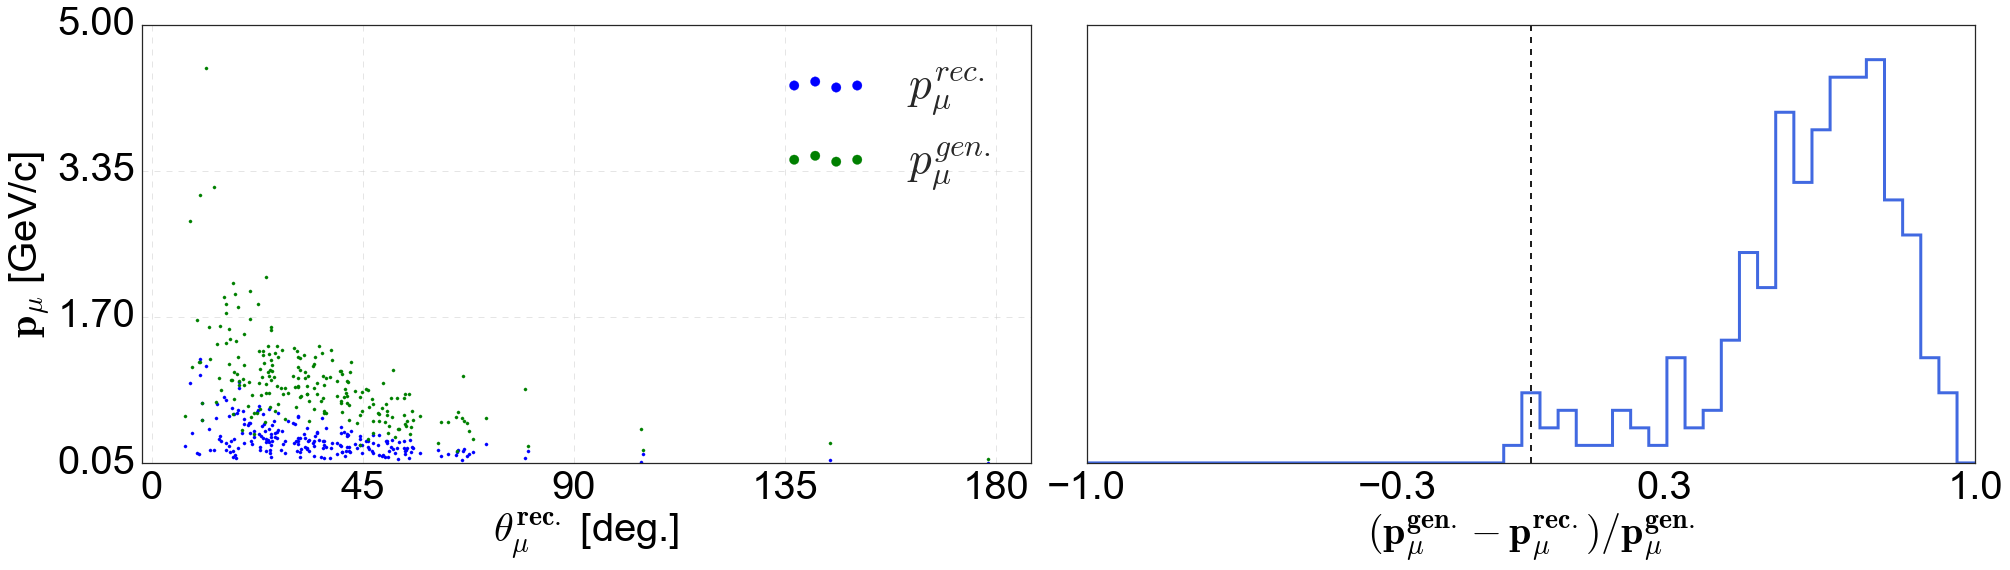

In [324]:
theta_min = 0

def multi_func(x, a0 ,a3 , a4 , a5 , a6, a7):
    return a0 + a4*np.power(x-15,a5)  
#     return a0/np.sqrt(np.abs(x-15)) + a3

def pow_func(x, a, b, c , d):
    return a*np.power(x,b) + c 

def sqrt_func(x, a, b,c):
    return a/np.sqrt(x-c) + b

# sample = detected_bad_sample[180./np.pi*detected_bad_sample['reco_CC1p_Pmu_theta']>theta_min]
sample = detected_bad_sample[180./np.pi*detected_bad_sample['reco_CC1p_Pmu_theta']<180]

corr_type = 'y_reco + pow_func(x, *popt_true) - pow_func(x, *popt_reco)'
corr_type = 'pow_func(x, *popt_true)'

varx = 'Pmu_theta';
vary = 'Pmu'
fig=plt.figure(figsize=(28,8))
ax=fig.add_subplot(1,2,1)

x = 180./np.pi*sample['reco_CC1p_'+varx]
y_reco = sample['reco_CC1p_'+vary]
y_true = sample['truth_'+vary]

ax.scatter(x,y_reco,s=10,color='blue',label='$p^{rec.}_{\\mu}$')
ax.scatter(x,y_true,s=10,color='green',label='$p^{gen.}_{\\mu}$')
set_axes(ax,'$\\bf{\\theta^{rec.}_{\\mu}}$ [deg.]','$\\bf{p_{\\mu}}$ [GeV/c]'
             ,fontsize=40,ticks_color=ticks_color)
ax.set_ylim(0.05,5)
ax.legend(fontsize=45 , markerscale=3., scatterpoints=4 )
ax.grid(linestyle='--',alpha=0.5)
ax.xaxis.set_ticks([0,45,90,135,180])

# x_fit = np.linspace(np.min(ax.get_xlim()), np.max(ax.get_xlim()), 100)
# popt_reco, pcov_reco = curve_fit(pow_func, x, y_reco , (1,-0.5,0,theta_min), maxfev=5000)
x_fit = np.linspace(theta_min, np.max(ax.get_xlim()), 100)
# popt_reco, pcov_reco = curve_fit(sqrt_func, x, y_reco , (1,1,0), maxfev=5000)
# print 'popt_reco:',popt_reco
# plt.plot(x_fit, sqrt_func(x_fit, *popt_reco), '--', c='blue',linewidth=3)
# plt.plot(x_fit, pow_func(x_fit, *popt_reco), '--', c='blue',linewidth=3)
popt_reco, pcov_reco = curve_fit(multi_func, x, y_reco , maxfev=5000)
plt.plot(x_fit, multi_func(x_fit, *popt_reco), '--', c='blue',linewidth=3)



# popt_true, pcov_true = curve_fit(pow_func, x, y_true , (1,-0.5,0,theta_min), maxfev=5000)
# popt_true, pcov_true = curve_fit(sqrt_func, x, y_true , (1,1,10), maxfev=5000)
print 'popt_true:',popt_true
# plt.plot(x_fit, sqrt_func(x_fit, *popt_true), '--', c='green',linewidth=3)
# plt.plot(x_fit, pow_func(x_fit, *popt_true), '--', c='green',linewidth=3)

popt_true, pcov_true = curve_fit(multi_func, x, y_true, maxfev=5000)
plt.plot(x_fit, multi_func(x_fit, *popt_true), '--', c='green',linewidth=3)


if corr_type == 'y_reco + pow_func(x, *popt_true) - pow_func(x, *popt_reco)':
#         y_corrected = y_reco + sqrt_func(x, *popt_true) - sqrt_func(x, *popt_reco)
        y_corrected = y_reco + multi_func(x, *popt_true) - multi_func(x, *popt_reco)

elif corr_type == 'pow_func(x, *popt_true)':
#         y_corrected = sqrt_func(x, *popt_true)
        y_corrected = multi_func(x, *popt_true)

ax.scatter(x,y_corrected,s=30,color='black',label='$p^{rec.}_{\\mu}$',alpha=0.3)

ax=fig.add_subplot(1,2,2)
bins=np.linspace(-1,1,50)
plt.hist((y_true-y_reco)/y_true,color='royalblue',bins=bins,label='before correction',histtype='step',linewidth=3)
# plt.hist((y_true-y_corrected)/y_true,color='black',bins=bins,label='after correction',histtype='step',linewidth=3)
set_axes(ax,'$\\bf{(p^{gen.}_{\\mu}-p^{rec.}_{\\mu})/p^{gen.}_{\\mu}}$',fontsize=40,ticks_color=ticks_color)
ax.xaxis.set_ticks([-1,-0.3,0.3,1])
ax.yaxis.set_major_formatter(ticker.NullFormatter())
plt.plot([0,0],ax.get_ylim(),'--',color='black')    
plt.tight_layout()

In [251]:
np.min(sample['reco_CC1p_Pmu_theta'])

0.12497799999999999

In [5]:
def plot_momentum_vs_theta(sample = MCC8_MCBNB_extBNBIsVertexReconstructed
                           ,varx = 'Pmu_theta',vary = 'Pmu',p_name='\\mu',ticks_color='white',ylim=None):

    fig=plt.figure(figsize=(18,6))
    ax=fig.add_subplot(1,2,1)
    x_label = '$\\theta^{rec.}_{%s}$ [deg.]'%(p_name)
    x = 180./np.pi*sample['reco_CC1p_'+varx]
    y_reco = sample['reco_CC1p_'+vary]
    y_true = sample['truth_'+vary]
    ax.scatter(x,y_reco,s=10,color='blue',label='$p^{rec.}_{%s}$'%p_name)
    ax.scatter(x,y_true,s=10,color='green',label='$p^{gen.}_{%s}$'%p_name)
    set_axes(ax,x_label=x_label,y_label='$p^{gen./rec.}_{%s}$ [GeV/c]'%p_name,fontsize=40,ticks_color=ticks_color)
    ax.set_xlim(-1,190);
    if ylim is None: ax.set_ylim(0.05,5);
    else: ax.set_ylim(ylim);
    ax.legend(fontsize=35 , markerscale=3., scatterpoints=4 )
    ax.grid(linestyle='--',alpha=0.5)
    ax.xaxis.set_ticks([0,45,90,135,180])
    plt.tight_layout()

    ax=fig.add_subplot(1,2,2)
    ax.scatter(x,(y_true-y_reco)/y_true,s=30)
    set_axes(ax,x_label=x_label,y_label='$ (p^{gen.}_{%s}-p^{rec.}_{%s}) / p^{gen.}_{%s}$'%(p_name,p_name,p_name)
             ,fontsize=40,ticks_color=ticks_color)    
    ax.xaxis.set_ticks([0,45,90,135,180])
    ax.set_xlim(-1,190);ax.set_ylim(-1,1)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    
    plt.tight_layout()

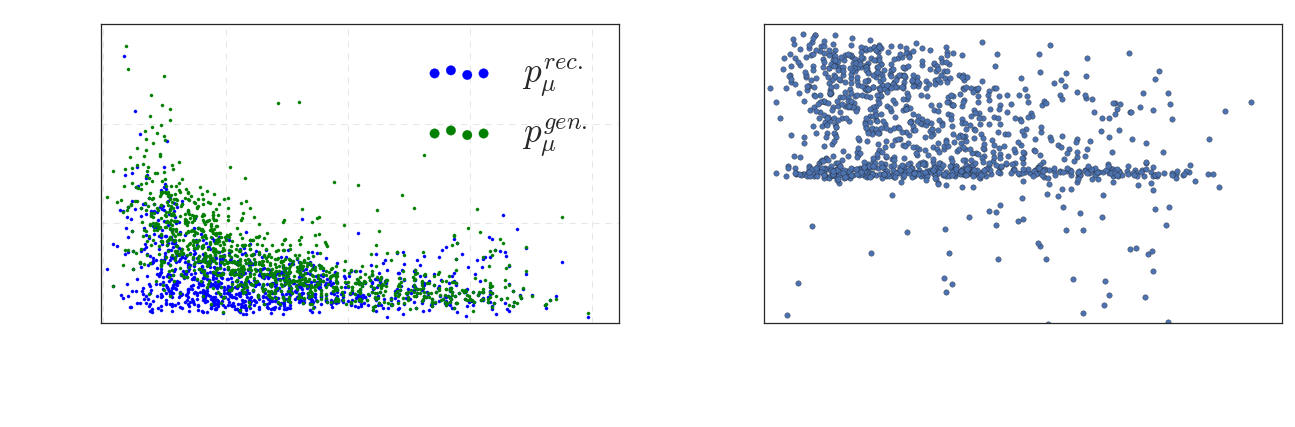

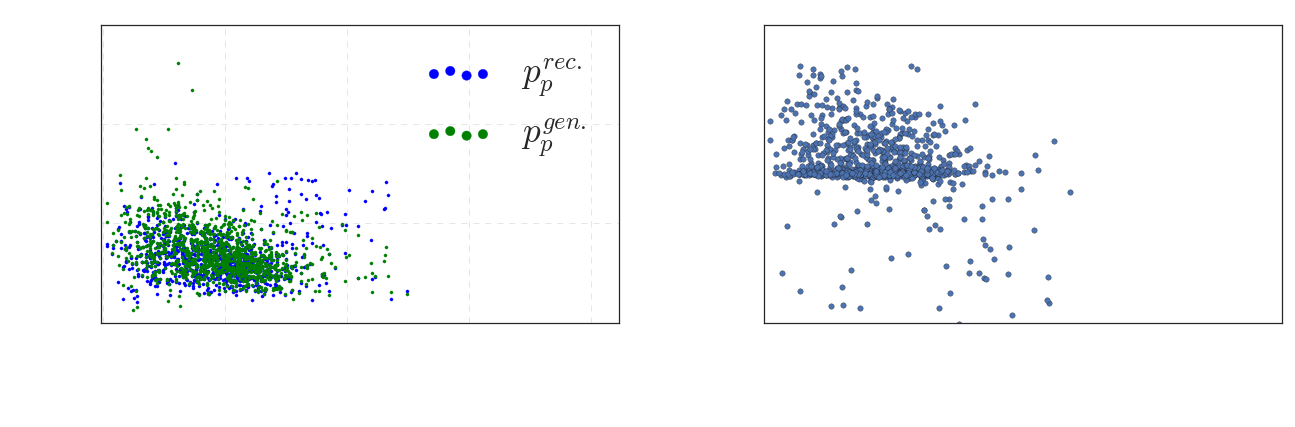

In [49]:
plot_momentum_vs_theta(sample = MCC8_MCBNB_extBNBIsVertexReconstructed
                           ,varx = 'Pmu_theta',vary = 'Pmu',p_name='\\mu',ticks_color='white',ylim=(0,3))
plot_momentum_vs_theta(sample = MCC8_MCBNB_extBNBIsVertexReconstructed
                           ,varx = 'Pp_theta',vary = 'Pp',p_name='p',ticks_color='white',ylim=(0,3))